In [3]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(Sierra)
library(presto)
library(ggplot2)
library(msigdbr)
library(fgsea)
library(Seurat)
library(tidyverse)
setwd('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/')

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::tail' by 'utils::tail' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::head' by 'utils::head' when loading 'Sierra'"
Loading required package: Rcpp

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Registered S3 method overwritten by 'cli':
  method     f

In [ ]:
data_dir <- '/data/APAproject//post_qual//data//Dimitry_Velmeshev_ASD/count_matrices/raw_matrix/'
ge_so <- Read10X(data.dir = data_dir)

In [ ]:
ge_so = CreateSeuratObject(counts = ge_so)

In [ ]:
metadata <- data.frame(read_table(paste0(data_dir,'meta.txt')))
metadata = metadata[,1:13]
rownames(metadata) <-  metadata$cell
head(metadata)

In [ ]:
ge_so <- AddMetaData(ge_so, metadata = metadata)
ge_so

In [ ]:
process_pca <- function (so, n_features){
    so <- NormalizeData(so, normalization.method = "LogNormalize",scale.factor = 10000, verbose = F)
    so <- FindVariableFeatures(object = so,selection.method = "vst", nfeatures = n_features, verbose = F)
    so <- ScaleData(so, features = rownames(so))
    so <- RunPCA(so, features = VariableFeatures(object = so), verbose = F)
    return(so)
}

In [ ]:
ge_so <- subset(ge_so , subset=diagnosis=='Control')
ge_so <- process_pca(ge_so, 2000)
ElbowPlot(ge_so)

In [ ]:
ge_so <- RunUMAP(ge_so , dims = 1:20, min.dist = 0.001,  n_neighbors = 50)    ##parameteres need to be set
ge_so <- FindNeighbors(ge_so, dims = 1:20)
#find cluster
ge_so <- FindClusters(ge_so, resolution =1)
DimPlot(ge_so, reduction='umap', group.by='cluster')
DimPlot(ge_so, reduction='umap', group.by='Capbatch', label = T)

In [ ]:
DimPlot(ge_so, reduction='umap', group.by='seurat_clusters', label=T)
DimPlot(ge_so, reduction='umap', group.by='cluster', label=T)
DimPlot(ge_so, reduction='umap', group.by='sample', label=T)

In [ ]:
table(ge_so$cluster)

In [ ]:
ge_so$neuron_type <- 'Other'

In [ ]:
IN_idx <- which(ge_so$cluster %in% c('IN-SST','IN-VIP','IN-SV2C','IN-PV'))
ge_so$neuron_type[IN_idx] = 'Inhibitory_Neurons'

In [ ]:
Ex_idx <- which(ge_so$cluster %in% c('L2/3','L4',' L5/6','L5/6-CC','Neu-NRGN-II','Neu-NRGN-I','Neu-mat'))
ge_so$neuron_type[Ex_idx] = 'Excitatory_Neurons'

In [ ]:
ge_so$main_cellTypes <- 'NA'
IN_idx <- which(ge_so$cluster %in% c('IN-SST','IN-VIP','IN-SV2C','IN-PV'))
ge_so$main_cellTypes[IN_idx] = 'Inhibitory_Neurons'
##
Ex_idx <- which(ge_so$cluster %in% c('L2/3','L4','L5/6','L5/6-CC','Neu-NRGN-II','Neu-NRGN-I','Neu-mat'))
ge_so$main_cellTypes[Ex_idx] = 'Excitatory_Neurons'
##
En_idx <- which(ge_so$cluster %in% c('Endothelial'))
ge_so$main_cellTypes[En_idx] = 'Endothelial'
##
Ast_idx <- which(ge_so$cluster %in% c('AST-FB','AST-PP'))
ge_so$main_cellTypes[Ast_idx] = 'Astrocytes'
##
Mg_idx <- which(ge_so$cluster %in% c('Microglia'))
ge_so$main_cellTypes[Mg_idx] = 'Microglia'
##
Og_idx <- which(ge_so$cluster %in% c('Oligodendrocytes'))
ge_so$main_cellTypes[Og_idx] = 'Oligodendrocytes'

##
OPC_idx <- which(ge_so$cluster %in% c('OPC'))
ge_so$main_cellTypes[OPC_idx] = 'OPC'

In [ ]:
DimPlot(ge_so, reduction='umap', group.by='neuron_type', label=T)
DimPlot(ge_so, reduction='umap', group.by='main_cellTypes', label=T)
DimPlot(ge_so, reduction='umap', group.by='cluster', label=T)

In [ ]:
table(ge_so$main_cellTypes)

## QCed and processed bam files are stored here 
### /data/APAproject/pre_qual/controls_raw/QCed_for_APA_usage_study

In [ ]:
## get the cell barcodes per patient and then filter the main bamfiles to only keep the QCed cellbarcodes. 
head(Cells(ge_so))

In [ ]:
cells_samples <- data.frame(ge_so$sample)
samples <- unique(cells_samples$ge_so.sample)
dir_to_save <- '/data/APAproject/pre_qual/controls_raw/QCed_for_APA_usage_study/'
for (sample in samples){
    outname <- paste0(dir_to_save, sample,'_filtered_barcodes.tsv')
    prefix <- paste0("_", sample)
    df <- gsub(prefix,"",rownames(cells_samples[cells_samples$ge_so.sample==sample,,drop=F]))
    write.table(df, file = outname,row.names = F, col.names = F, quote = FALSE)
}

In [ ]:
## extract the qced cells from main bam file and then submit to Sierra pipeline

In [ ]:
tst <- read.table('/data/APAproject/pre_qual/controls_raw/QCed_for_APA_usage_study/filtered_bams/metadata_for_sierra.txt', header=T)
tst

In [ ]:
library(Sierra)
library(dplyr)
library(stringr)
workingdir <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/Sierra_out_1/'
setwd(workingdir)
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/bams_in/'
samples <- read.table(paste0(root,'metadata_for_sierra.txt'), header = T)
peak.output.file <- c(paste0(samples$name, '_FindPeak_out'))
L <- dim(samples)[1]
print('Step 1: Samples are read and now performing the peak calling per sample')
for (row in 1:L){
    FindPeaks(output.file = peak.output.file[row],      # output filename
    gtf.file = reference.file,                   # gene model as a GTF file
    bamfile = paste0(root,samples[row,]$bam),                   # BAM alignment filename.
    junctions.file = paste0(root,samples[row,]$junctions),     # BED filename of splice junctions exising in BAM file. 
    ncores = 32)
}

print('Step 2: peak calling per sample is done now mergeing the peaks')
peak.dataset.table = data.frame(Peak_file = peak.output.file,
  Identifier = samples$name,
  stringsAsFactors = FALSE)
peak.merge.output.file = "DimitryV_merged_peaks.txt"
MergePeakCoordinates(peak.dataset.table, output.file = peak.merge.output.file, ncores = 32)
####
print('Step 3: merging is done now counting the per peak, this can take a while')

count.dir <- paste0(samples$name, "_sierra_counts")
for (row in 1:L){
    print(count.dir[row])
    CountPeaks(peak.sites.file = peak.merge.output.file,
    gtf.file = reference.file,
    bamfile = paste0(root,samples[row,]$bam),
    whitelist.file = paste0(root,samples[row,]$barcodes),
    output.dir = count.dir[row],
    countUMI = TRUE,
    ncores = 32)

}

print('Step 4: counting is done now aggeragating the peaks for all samples')
count.dir <- paste0(samples$name, "_sierra_counts")
barcode_extensions <- data.frame(samples$name)
colnames(barcode_extensions) <- c('ext')
barcode_extensions <- paste0("_",barcode_extensions$ext)
print(barcode_extensions)
out.dir <- "DimitryV_Sierra_aggregate"
#Now aggregate the counts for all datasets
AggregatePeakCounts(peak.sites.file = peak.merge.output.file,
                    count.dirs = count.dir,
                    exp.labels = barcode_extensions,
                    output.dir = out.dir)



In [ ]:
## Save the objects and free the memory


In [ ]:
saveRDS(object = ge_so,
        file = '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_celltypes_GE.rds')

In [ ]:
ge_so <- readRDS('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_celltypes_GE.rds')

In [ ]:
setwd('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/')

In [ ]:
## read and annotated the aggregated peaks
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
Agg_peak <- read.table('Sierra_out_1/DimitryV_merged_peaks.txt',header = T)
Agg_peak

In [ ]:
genome <- BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38
print('Aggeration is done; now annotating the peaks')
AnnotatePeaksFromGTF(peak.sites.file = 'Sierra_out_1/DimitryV_merged_peaks.txt', 
                     gtf.file = reference.file,
                     output.file = "Sierra_out_1/DimitryV_peaks_annotated.txt", 
                     genome = genome)
print('Last step 5: reading and writing the annotated peak counts')


In [ ]:
#Read in peak annotations
peak.annotations <- read.table("Sierra_out_1/DimitryV_peaks_annotated.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
peak.annotations

In [ ]:
## make a seurat object
peak.counts <- ReadPeakCounts(data.dir = "Sierra_out_1/DimitryV_Sierra_aggregate/")
peaks.seurat <- NewPeakSeurat(peak.data = peak.counts, 
                              annot.info = peak.annotations, 
                              min.cells = 0, min.peaks = 200)

In [ ]:
peaks.seurat

In [ ]:
DimPlot(ge_so, reduction='umap', group.by='seurat_clusters')

In [ ]:
peaks.seurat <- process_pca(peaks.seurat, 4000)
ElbowPlot(peaks.seurat)

In [ ]:
peaks.seurat <- RunUMAP(peaks.seurat , dims = 1:20, min.dist = 0.001,  n_neighbors = 25)    ##parameteres need to be set
peaks.seurat <- FindNeighbors(peaks.seurat, dims = 1:20)
#find cluster
peaks.seurat <- FindClusters(peaks.seurat, resolution =1)

In [ ]:
peaks.seurat <- AddMetaData(peaks.seurat, metadata = ge_so@meta.data)

In [ ]:
DimPlot(peaks.seurat, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(peaks.seurat, reduction='umap', group.by='cluster', label=T)
DimPlot(peaks.seurat, reduction='umap', group.by='seurat_clusters',label=T)

In [ ]:
saveRDS(object = peaks.seurat, file = 'rdata/Control_celltypes_peaks.rds')

In [ ]:
peaks_so <- readRDS('rdata/Control_celltypes_peaks.rds')


In [ ]:
peaks_so <- process_pca(peaks_so, 4000)

In [ ]:
ElbowPlot(peaks_so)

## Ok its a bitimessed up here!!! have to do some stuff again so the order is not really true in this notebook!
### it is better to use only one UMAP to study the celltypes and subclusters!
# Chapter1
### 1-get the overal dimplots from gene expression profiles
### 2-subset neurons, and do the subclustering
### 3-make the overal peaks file and add the metadata
### 4-subset the neurons from peaks seurat object and add the metadata!

In [ ]:
ge_so <- readRDS('rdata/Control_celltypes_GE.rds')
#Read in peak annotations
peak.annotations <- read.table("Sierra_out_1/DimitryV_peaks_annotated.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
peak.annotations

In [ ]:
peak.counts <- ReadPeakCounts(data.dir = "Sierra_out_1/DimitryV_Sierra_aggregate/")
peaks_so <- PeakSeuratFromTransfer(peak.data = peak.counts, 
                                       genes.seurat = ge_so, 
                                       annot.info = peak.annotations, 
                                       min.cells = 10, min.peaks = 200)
peaks_so

In [ ]:
peaks_so <- AddMetaData(peaks_so, metadata=ge_so@meta.data)

In [ ]:
DimPlot(peaks_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(peaks_so, reduction='umap', group.by='cluster', label=T)
DimPlot(peaks_so, reduction='umap', group.by='seurat_clusters',label=T)
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'DimV_brain_celltypes_and_subclusters.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(peaks_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(peaks_so, reduction='umap', group.by='cluster', label=T)
DimPlot(peaks_so, reduction='umap', group.by='seurat_clusters',label=T)
dev.off()

## So the peaks makes same amount of clusters! which I think its a good thing. 
## Now the interesting thing is despite well labeld map we still have more subclusters than cell types. so I'm wondering if we can see difference in APA usage of these subclusters! it would be the golden nugget

In [ ]:
DimPlot(ge_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(ge_so, reduction='umap', group.by='cluster', label=T)
DimPlot(ge_so, reduction='umap', group.by='seurat_clusters',label=T)
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'DimV_brain_celltypes_and_subclusters.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(ge_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(ge_so, reduction='umap', group.by='cluster', label=T)
DimPlot(ge_so, reduction='umap', group.by='seurat_clusters',label=T)
dev.off()

In [ ]:
## lets first subset the the Neurons as the main dataset is huge!
neurons_ge_so <- subset(ge_so, subset=main_cellTypes %in% c("Excitatory_Neurons","Inhibitory_Neurons"))
neurons_ge_so

In [ ]:
neurons_ge_so <- FindVariableFeatures(object = neurons_ge_so,
                                   selection.method = "vst", nfeatures = 2000, verbose = F)
neurons_ge_so <- RunPCA(neurons_ge_so, features = VariableFeatures(object = neurons_ge_so), verbose = F)
ElbowPlot(neurons_ge_so)

In [ ]:
neurons_ge_so <- RunUMAP(neurons_ge_so , dims = 1:20, min.dist = 0.001,  n_neighbors = 25, verbose=F)    ##parameteres need to be set
neurons_ge_so <- FindNeighbors(neurons_ge_so, dims = 1:20)
#find cluster
neurons_ge_so <- FindClusters(neurons_ge_so, resolution =1)

In [ ]:
DimPlot(neurons_ge_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(neurons_ge_so, reduction='umap', group.by='cluster', label=T)
DimPlot(neurons_ge_so, reduction='umap', group.by='seurat_clusters',label=T)
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'Neurons_and_subtupes.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(neurons_ge_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(neurons_ge_so, reduction='umap', group.by='cluster', label=T)
DimPlot(neurons_ge_so, reduction='umap', group.by='seurat_clusters',label=T)
dev.off()

In [ ]:
Cellnames <- Cells(neurons_ge_so)
head(Cellnames)

In [ ]:
## to subset raw Neurons (or other celltypes) with no UMAP(so we can add the celltype specific UMAP
## coordinates to the peaks subset we need to load the peaks_so again and subset based on cellnames)
print(dim(peak.counts))
peak.counts <- peak.counts[,colnames(peak.counts) %in% Cellnames]
print(dim(peak.counts))
neurons_peaks_so <- PeakSeuratFromTransfer(peak.data = peak.counts, 
                                       genes.seurat = neurons_ge_so, 
                                       annot.info = peak.annotations, 
                                       min.cells = 10, min.peaks = 200)

neurons_peaks_so <- AddMetaData(neurons_peaks_so, metadata=neurons_ge_so@meta.data)

In [ ]:
saveRDS(object = neurons_peaks_so, file = 'rdata/neurons_peaks_so.rds',compress = T)
saveRDS(object = neurons_ge_so, file='rdata/neurons_peaks_so.rds', compress=T)
saveRDS(object = ge_so, file = 'rdata/Control_celltypes_GE.rds',compress=T)
saveRDS(object = peaks_so, file = 'rdata/Control_celltypes_peaks.rds', compress=T)

In [ ]:
DimPlot(neurons_peaks_so, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(neurons_peaks_so, reduction='umap', group.by='cluster', label=T)
DimPlot(neurons_peaks_so, reduction='umap', group.by='seurat_clusters',label=T)

In [ ]:
## 3'UTR global shifts and APA usage in general neuron types IN vs Ex
neurons_peaks_so <- SetIdent(neurons_peaks_so, value = "main_cellTypes")
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
gtf_gr <- rtracklayer::import(reference.file)
gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")
IE_neruons_UTR_shift <- DetectUTRLengthShift(peaks.object = neurons_peaks_so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "Excitatory_Neurons", 
                                  population.2 = "Inhibitory_Neurons")
PlotUTRLengthShift(IE_neruons_UTR_shift)

In [ ]:
plotname <- paste0(results_root, 'Neurons_IvsE_3UTR_shift.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
PlotUTRLengthShift(IE_neruons_UTR_shift)
dev.off()

In [ ]:
plotname <- paste0(results_root, 'Neurons_IvsE_APAusage.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
IE_neruons_APA_usage <- DetectAEU(peaks.object = neurons_peaks_so, 
                       gtf_gr = gtf_gr,
                       gtf_TxDb = gtf_TxDb,
                       do.MAPlot = T,
                       population.1 = "Excitatory_Neurons", 
                       population.2 = "Inhibitory_Neurons")
IE_neruons_APA_usage

In [ ]:
IE_neruons_UTR_shift

In [ ]:
IE_neruons_APA_usage[IE_neruons_APA_usage['population1_pct'] > 0.10 & IE_neruons_APA_usage['population2_pct'] < 0.03,]

In [ ]:
IE_neruons_APA_usage[IE_neruons_APA_usage['population1_pct'] < 0.03 & IE_neruons_APA_usage['population2_pct'] > 0.10,]

## so wirte a piece of code that does the global shift analysis for:
### 1- all the subclusters combinations in each neuron category
### 2- all the subclusters cobinations for all neuron types
## also do and save the results for APA usage and save the global shif tables as well.


In [ ]:
neurons_peaks_so <- readRDS('rdata/neurons_peaks_so.rds')

In [ ]:
table(neurons_peaks_so$cluster)

In [ ]:
combn(unique(neurons_peaks_so$cluster), 2)

In [ ]:
neurons_peaks_so <- SetIdent(neurons_peaks_so, value = "cluster")

In [ ]:
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
gtf_gr <- rtracklayer::import(reference.file)
gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")
# IE_neruons_UTR_shift <- DetectUTRLengthShift(peaks.object = neurons_peaks_so, 
#                                   gtf_gr = gtf_gr,
#                                   gtf_TxDb = gtf_TxDb,
#                                   population.1 = "Excitatory_Neurons", 
#                                   population.2 = "Inhibitory_Neurons")

In [ ]:
p <- PlotUTRLengthShift(IE_neruons_UTR_shift, plot.title = "Inhibitory vs Excitatory Neurons 3'UTR shifts")

In [ ]:
neurons_peaks_so <- SetIdent(neurons_peaks_so, value = "main_cellTypes")


In [ ]:
IE_neruons_APA_usage <- DetectAEU(peaks.object = neurons_peaks_so, 
                                 gtf_gr = gtf_gr,
                                 gtf_TxDb = gtf_TxDb,
                                 do.MAPlot = T,
                                 population.1 = "Neu-NRGN-II", 
                                 population.2 = "L5/6-CC")

In [ ]:
print(IE_neruons_APA_usage

In [ ]:
tst <- DetectUTRLengthShift(peaks.object = neurons_peaks_so, 
                                    gtf_gr = gtf_gr,
                                    gtf_TxDb = gtf_TxDb,
                                    population.1 = "Neu-NRGN-II", 
                                    population.2 = "L5/6-CC")

In [ ]:
PlotUTRLengthShift(tst)

In [ ]:
DEXSeq::plotMA(dxr1, alpha = adj.pval.thresh,
                                ylim = c(min(dxr1$log2fold_target_comparison), max(dxr1$log2fold_target_comparison)))

In [ ]:
IE_neruons_APA_usage <- DetectAEU(peaks.object = neurons_peaks_so, 
                                 gtf_gr = gtf_gr,
                                 gtf_TxDb = gtf_TxDb,
                                 do.MAPlot = T,
                                 population.1 = "Neu-NRGN-II", 
                                 population.2 = "L5/6-CC")

In [ ]:
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'Neurons_IvsE_3UTR_shift.pdf')
page = pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
print(page, PlotUTRLengthShift(IE_neruons_UTR_shift, plot.title = "Inhibitory vs Excitatory Neurons 3'UTR shifts"))
printImage(PlotUTRLengthShift(IE_neruons_UTR_shift, plot.title = "Inhibitory vs Excitatory Neurons 3'UTR shifts"), "someimage.jpg")
close(page)

In [ ]:

library(foreach)
library(doParallel)

combinations <-  combn(unique(neurons_peaks_so$cluster), 2)
cores=detectCores()
cl <- makeCluster(cores[1]-20) #not to overload your computer
registerDoParallel(cl)

finalMatrix <- foreach(i=1:ncol(combinations)) %dopar% {
  #tempMatrix = functionThatDoesSomething() #calling a function
  #do other things if you want
  print(combinations[1, i])
  #tempMatrix #Equivalent to finalMatrix = cbind(finalMatrix, tempMatrix)
}
#stop cluster
stopCluster(cl)

In [ ]:
table(neurons_peaks_so$region)

In [ ]:
DimPlot(neurons_peaks_so , reduction='umap', group.by='region')

# chapter2
## for simplicity its better if I just focus on the frontol cortex regions! so:
### 1- subset the PFC from Dimitry et al for all the celltypes
### 2- use the Dim et al map as reference to label the neurons in Kapmann
### 3- start comparing the Kapmann and normal
### 4- add more datasets (Marinaro et al,  and Mathys et al)

In [ ]:
neurons_ge_so <- readRDS('rdata/neurons_ge_so.rds')
neurons_ge_so_PFC <- subset(neurons_ge_so, subset=region=='PFC')
neurons_ge_so_PFC

In [ ]:
neurons_ge_so_PFC <- FindVariableFeatures(object = neurons_ge_so_PFC,
                                   selection.method = "vst", nfeatures = 2000, verbose = F)
neurons_ge_so_PFC <- RunPCA(neurons_ge_so_PFC, features = VariableFeatures(object = neurons_ge_so),
                            verbose = F)
ElbowPlot(neurons_ge_so_PFC)

In [ ]:
neurons_ge_so_PFC <- RunUMAP(neurons_ge_so_PFC , dims = 1:20, min.dist = 0.001,  n_neighbors = 25, verbose=F)    ##parameteres need to be set
neurons_ge_so_PFC <- FindNeighbors(neurons_ge_so_PFC, dims = 1:20)
#find cluster
neurons_ge_so_PFC <- FindClusters(neurons_ge_so_PFC, resolution =1)

In [ ]:
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='cluster', label=T)
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='seurat_clusters',label=T)
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'PFC_Neurons_and_subtupes.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='main_cellTypes',label=T)
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='cluster', label=T)
DimPlot(neurons_ge_so_PFC, reduction='umap', group.by='seurat_clusters',label=T)
dev.off()

In [ ]:
saveRDS(neurons_ge_so_PFC, 'rdata/PFC_neurons_ge_so.rds')

In [ ]:
### PFC_neuron_peaks_so also generated and saved in rdata

In [ ]:
# lets load SFG neurons from Kapmann and label them
SFG_AD_ECneurons_so <- readRDS('/data/APAproject/post_qual/data//Kapmann/from_paper/sce.SFG.Exc.scAlign.rds')
SFG_AD_INneurons_so <- readRDS('/data/APAproject/post_qual/data//Kapmann/from_paper/sce.SFG.Inh.scAlign.rds')

In [ ]:
SFG_AD_ECneurons_so <- as.Seurat(SFG_AD_ECneurons_so)
SFG_AD_INneurons_so <- as.Seurat(SFG_AD_INneurons_so)

In [ ]:
table(SFG_AD_ECneurons_so$subclusterAssignment)

In [ ]:
DimPlot(SFG_AD_ECneurons_so, reduction='TSNE', group.by='subclusterAssignment')

In [ ]:
## merge the Ex and In neurons:
SFG_all_neurons <- merge(SFG_AD_ECneurons_so, SFG_AD_INneurons_so)
SFG_all_neurons

In [ ]:
SFG_all_neurons <- process_pca(SFG_all_neurons,2000)
ElbowPlot(SFG_all_neurons)

In [ ]:
SFG_all_neurons <- RunUMAP(SFG_all_neurons , dims = 1:20, min.dist = 0.001,  n_neighbors = 25, verbose=F)    ##parameteres need to be set
SFG_all_neurons <- FindNeighbors(SFG_all_neurons, dims = 1:20)
#find cluster
SFG_all_neurons <- FindClusters(SFG_all_neurons, resolution =1)

In [ ]:
DimPlot(SFG_all_neurons, reduction='umap', group.by='subclusterAssignment',label=T)
DimPlot(SFG_all_neurons, reduction='umap', group.by='seurat_clusters',label=T)
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'SFG_Neurons_and_subtupes.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(SFG_all_neurons, reduction='umap', group.by='subclusterAssignment',label=T)
DimPlot(SFG_all_neurons, reduction='umap', group.by='seurat_clusters',label=T)
dev.off()

## ok now lets annotate these clusters using the control reference!

In [ ]:
neuron.anchors <- FindTransferAnchors(reference = neurons_ge_so, query = SFG_all_neurons,
                                      dims = 1:20, reference.reduction = "pca")

In [ ]:
pedictions <- TransferData(anchorset = neuron.anchors, refdata = neurons_ge_so$cluster, dims = 1:20)
SFG_all_neurons_labeled <- AddMetaData(SFG_all_neurons, metadata = predictions)

In [ ]:
SFG_all_neurons_labeled <- MapQuery(anchorset = neuron.anchors, reference = neurons_ge_so_PFC,
                                    query = SFG_all_neurons, refdata = list(celltype = "cluster"),
                                    reference.reduction = "pca", reduction.model = "umap")

In [ ]:
table(SFG_all_neurons_labeled$predicted.id)

In [ ]:
p1 <- DimPlot(neurons_ge_so_PFC, reduction = "umap", group.by = "cluster", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference Control annotations")
p2 <- DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "predicted.id", label = TRUE,
    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("AD transferred labels")
p1 + p2
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, '{FC_Control_vs_SFG_Neurons_annotated.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
p1 + p2
dev.off()

In [ ]:
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "subclusterAssignment", label = TRUE)
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "predicted.id", label = TRUE)
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "seurat_clusters", label = TRUE)
plotname <- paste0(results_root, 'SFG_Neurons_pre_post_annotation.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "subclusterAssignment", label = TRUE)
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "predicted.id", label = TRUE)
DimPlot(SFG_all_neurons_labeled, reduction = "umap", group.by = "seurat_clusters", label = TRUE)
dev.off()

## So we have the SFG map! now I guess the best is to get the barcodes of the SFG and do the peaks calling!

In [ ]:
table(SFG_all_neurons_labeled$SampleID)

In [ ]:
SFG_AD_all_cells_so <- readRDS('/data/APAproject/post_qual/data//Kapmann/from_paper/sce.SFG.scAlign.assigned.rds')
SFG_AD_all_cells_so <- as.Seurat(SFG_AD_all_cells_so)

In [ ]:
Cells(SFG_AD_all_cells_so)[1:10]

In [ ]:
SFG1_cells <- Cells(SFG_AD_all_cells_so)[which(startsWith(Cells(SFG_AD_all_cells_so), 'SFG1_'))]
SFG1_cells <- paste0(gsub('SFG1_','', SFG1_cells),"-1")
SFG1_cells

In [ ]:
samples <- unique(SFG_AD_all_cells_so$SampleID)
for (id in samples){
    cell_barcodes <- Cells(SFG_AD_all_cells_so)[which(startsWith(Cells(SFG_AD_all_cells_so), id))]
    cell_barcodes <- paste0(gsub(paste0(id,'_'),'', cell_barcodes),"-1")
    root <- "/data/APAproject/post_qual/data/Kapmann/raw_files/SFG_samples/QCed_barcodes/"
    outname <- paste0(root,id,'_barcodes.tsv')
    write.table(cell_barcodes, file = outname, row.names = F, quote = F,col.names = F)
}

In [ ]:
table(SFG_AD_all_cells_so$SampleID)

In [ ]:
saveRDS(SFG_all_neurons_labeled, file = 'rdata/SFG_all_Neurons.rds')

## read in and annotate the all celltypes together

In [ ]:
SFG_all_cells <- readRDS('/data/APAproject/post_qual/data//Kapmann/from_paper/sce.SFG.scAlign.assigned.rds')
SFG_all_cells <- as.Seurat(SFG_all_cells)
SFG_all_cells

In [ ]:
## read in the Dimitry reference:

In [ ]:
Dim_ge_so <- readRDS('rdata/Control_celltypes_GE.rds')
Dim_ge_so

In [ ]:
# ref.anchors <- FindTransferAnchors(reference = Dim_ge_so, query = SFG_all_cells,
#                                       dims = 1:20, reference.reduction = "pca")
pedictions <- TransferData(anchorset = ref.anchors, refdata = Dim_ge_so$cluster, dims = 1:20)
SFG_all_cells_labeled <- AddMetaData(SFG_all_cells, metadata = predictions)

In [ ]:
SFG_all_cells_labeled <- NormalizeData(SFG_all_cells_labeled, normalization.method = "LogNormalize",scale.factor = 10000, verbose = F)
SFG_all_cells_labeled <- FindVariableFeatures(object = SFG_all_cells_labeled,selection.method = "vst", nfeatures = 2000, verbose = F)
SFG_all_cells_labeled <- ScaleData(SFG_all_cells_labeled, features = rownames(SFG_all_cells_labeled))
SFG_all_cells_labeled <- RunPCA(SFG_all_cells_labeled, features = VariableFeatures(object = SFG_all_cells_labeled), verbose = F)
ElbowPlot(SFG_all_cells_labeled)

In [ ]:
SFG_all_cells_labeled <- RunUMAP(SFG_all_cells_labeled , dims = 1:20, min.dist = 0.001,  n_neighbors = 50)    ##parameteres need to be set
SFG_all_cells_labeled <- FindNeighbors(SFG_all_cells_labeled, dims = 1:20)
#find cluster
SFG_all_cells_labeled <- FindClusters(SFG_all_cells_labeled, resolution =1)

In [ ]:
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "clusterAssignment", label = TRUE)
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "predicted.id", label = TRUE)
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "seurat_clusters", label = TRUE)
plotname <- paste0(results_root, 'SFG_all_cells_pre_post_annotation.pdf')
pdf(file=plotname, width = 8.27, height = 11.69, paper='A4r', onefile=T)
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "clusterAssignment", label = TRUE)
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "predicted.id", label = TRUE)
DimPlot(SFG_all_cells_labeled, reduction = "umap", group.by = "seurat_clusters", label = TRUE)
dev.off()

In [ ]:
Dim_ge_so_PFC <- subset(Dim_ge_so, subset=region=='PFC')
Dim_ge_so_PFC


In [ ]:
Dim_ge_so_PFC$cellType <- paste0('Dim_',Dim_ge_so_PFC$cluster)

In [ ]:
saveRDS(Dim_ge_so_PFC, file='rdata/Control_cell_types_GE_PFC.rds')

In [ ]:
###
peaks_so_pfc <- readRDS('rdata/neurons_peaks_so.rds')
ge_so_pfc <- readRDS('rdata/neurons_ge_so.rds')
DimPlot(peaks_so_pfc, reduction='umap', group.by='cluster', label=T )
DimPlot(ge_so_pfc, reduction='umap', group.by='cluster', label=T )


In [ ]:
##load the DTU test:
L23vsINSV2C <- read.table('results/neuron_subtypes/Neu-NRGN-II_vs_IN-PV_APAusage_table.tsv', sep='\t')
L23vsINSV2C

In [ ]:
res.table.top <- subset(L23vsINSV2C, abs(Log2_fold_change) > 2)
res.table.top

In [ ]:
#GABRB3
peaks.to.plot <- rownames(subset(L23vsINSV2C, gene_name == "DLG2"))
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'peakUMAP_test_ARPP21.pdf')
pdf(file=plotname, width = 20, height = 11.69, onefile=T)
DimPlot(peaks_so_pfc, reduction='umap', group.by='cluster', label=T )
FeaturePlot(object = ge_so_pfc, features = 'DLG2', reduction = 'umap')
PlotRelativeExpressionUMAP(peaks_so_pfc, peaks.to.plot = peaks.to.plot, use.facet=F)
dev.off()
DimPlot(peaks_so_pfc, reduction='umap', group.by='cluster', label=T )
FeaturePlot(object = ge_so_pfc, features = 'DLG2', reduction = 'umap')
PlotRelativeExpressionUMAP(peaks_so_pfc, peaks.to.plot = peaks.to.plot, use.facet=F)

In [ ]:
FeaturePlot(object = ge_so_pfc, features = 'PRKAG2', reduction = 'umap')

In [ ]:
# reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
# gtf_gr <- rtracklayer::import(reference.file)
# gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")

peaks_so_pfc <- SetIdent(peaks_so_pfc, value=peaks_so_pfc$cluster)
# res.table = DUTest(peaks_so_pfc, 
#                    population.1 = "Neu-NRGN-II", 
#                    population.2 = NULL,
#                    exp.thresh = 0.1, 
#                    feature.type = c("UTR3"))
apa.res <- DetectAEU(peaks.object = peaks_so_pfc, 
                                 gtf_gr = gtf_gr,
                                 gtf_TxDb = gtf_TxDb,
                                 do.MAPlot = F,
                                 population.1 = 'Neu-NRGN-II',
                                population.2 = NULL)
apa.res

In [ ]:
res.table.top <- subset(apa.res, abs(Log2_fold_change) > 2)
res.table.top

In [ ]:
res.table.top %>% filter(population1_pct >= 0.1)

In [ ]:
peaks.to.plot <- rownames(subset(apa.res, gene_name == "PPP2R2B"))
FeaturePlot(object = ge_so_pfc, features = 'PPP2R2B', reduction = 'umap')
PlotRelativeExpressionUMAP(peaks_so_pfc, peaks.to.plot = peaks.to.plot, use.facet=F)

In [ ]:
# peaks_so_pfc <- NormalizeData(peaks_so_pfc, normalization.method = "LogNormalize",scale.factor = 10000, verbose = F)
# peaks_so_pfc <- FindVariableFeatures(object = peaks_so_pfc,selection.method = "vst", nfeatures = 2000, verbose = F)
# peaks_so_pfc <- ScaleData(peaks_so_pfc, features = rownames(peaks_so_pfc))
# peaks_so_pfc <- RunPCA(peaks_so_pfc, features = VariableFeatures(object = peaks_so_pfc), verbose = F)
peaks_so_pfc <- RunTSNE(peaks_so_pfc, dims = 1:20, perplexity=200)
DimPlot(peaks_so_pfc, reduction = 'tsne', group.by='cluster',label=T, repel=T)

In [ ]:
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'PPP2R2B_test.pdf')
pdf(file=plotname, width = 16, height = 11.69, onefile=T)
peaks.to.plot <- rownames(subset(apa.res, gene_name == "PPP2R2B"))
FeaturePlot(object = ge_so_pfc, features = 'PPP2R2B', reduction = 'umap')
PlotRelativeExpressionUMAP(peaks_so_pfc, peaks.to.plot = peaks.to.plot, use.facet=F)
PlotRelativeExpressionBox(peaks_so_pfc, peaks.to.plot = peaks.to.plot)
dev.off()

In [ ]:
results_root <- '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/results/'
plotname <- paste0(results_root, 'MYT1L_test.pdf')
pdf(file=plotname, width = 20, height = 11.69, onefile=T)
peaks.to.plot <- rownames(subset(apa.res, gene_name == "MYT1L"))
FeaturePlot(object = ge_so_pfc, features = 'MYT1L', reduction = 'umap')
PlotRelativeExpressionUMAP(peaks_so_pfc, peaks.to.plot = peaks.to.plot, use.facet=F)
PlotRelativeExpressionBox(peaks_so_pfc, peaks.to.plot = peaks.to.plot)
dev.off()

In [ ]:
utr_shift <- DetectUTRLengthShift(peaks.object = peaks_so_pfc, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = 'Neu-NRGN-II', 
                                  population.2 = NULL)

In [ ]:
plotname <- paste0(results_root, 'Neu-NRGN-II_3UTR_shift.pdf')
pdf(file=plotname, width = 20, height = 11.69, paper='A4r' ,onefile=T)
PlotUTRLengthShift(utr_shift)
dev.off()

# Chapter 2
## lets make a fully annotated map of Kapman ( remove the SFG7)  
### then I can merge the Dim with SFG and do the comparison I want to do.

In [ ]:
### doing these steps in the rstudio for better visualizaion, and the will move back here for the integrations
setwd('/data/APAproject/post_qual/data/Kapmann/raw_files/SFG_samples/')

In [ ]:
## read in and process peaks from Kapmann
genome <- BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38
print('Aggeration is done; now annotating the peaks')
peak.annotations <- AnnotatePeaksFromGTF(peak.sites.file = 'Sierra_out_1/Kapmann_merged_peaks.txt', 
                     gtf.file = reference.file,
                     output.file = "Sierra_out_1/Kapmann_peaks_annotated.txt", 
                     genome = genome)
peak.annotations

In [ ]:
peak.annotations <- read.table('Sierra_out_1/Kapmann_peaks_annotated.txt', sep='\t')
peak.annotations

In [ ]:
## read in the ge-so and subset out the SGF7 and then add the TSNE and UMAP cooridnates to new peaks so
SFG_AD_all_cells_so <- readRDS('/data/APAproject/post_qual/data//Kapmann/from_paper/sce.SFG.scAlign.assigned.rds')
SFG_AD_all_cells_so <- as.Seurat(SFG_AD_all_cells_so)
DimPlot(SFG_AD_all_cells_so, reduction = "TSNE", group.by = "clusterCellType", label = TRUE, repel=T)

In [ ]:
SFG_AD_all_cells_so <- NormalizeData(SFG_AD_all_cells_so, normalization.method = "LogNormalize",scale.factor = 10000, verbose = F)
SFG_AD_all_cells_so <- FindVariableFeatures(object = SFG_AD_all_cells_so,selection.method = "vst", nfeatures = 2000, verbose = F)
SFG_AD_all_cells_so <- ScaleData(SFG_AD_all_cells_so, features = rownames(SFG_AD_all_cells_so))
SFG_AD_all_cells_so <- RunPCA(SFG_AD_all_cells_so, features = VariableFeatures(object = SFG_AD_all_cells_so), verbose = F)
SFG_AD_all_cells_so <- RunUMAP(SFG_AD_all_cells_so , dims = 1:20, min.dist = 0.001,  n_neighbors = 50)    ##parameteres need to be set
SFG_AD_all_cells_so <- FindNeighbors(SFG_AD_all_cells_so, dims = 1:20)
#find cluster
SFG_AD_all_cells_so <- FindClusters(SFG_AD_all_cells_so, resolution =1)
DimPlot(SFG_AD_all_cells_so, reduction = 'umap', group.by='clusterCellType',label=T, repel=T)

In [ ]:
## now subset out the SFG7
SFG_AD_all_cells_so_filtered <- subset(SFG_AD_all_cells_so, subset=SampleID!='SFG7')
table(SFG_AD_all_cells_so_filtered$SampleID)

In [ ]:
DimPlot(SFG_AD_all_cells_so_filtered, reduction = "TSNE", group.by = "clusterCellType", label = TRUE, repel=T)

In [ ]:
saveRDS(SFG_AD_all_cells_so_filtered, file = '../../rdata/SFG_all_cells_ge_so_nosfg7.rds')

In [ ]:
## make a seurat object
peak.counts <- ReadPeakCounts(data.dir = "Sierra_out_1/Kapmann_Sierra_aggregate/")
SFG_peaks_so <- PeakSeuratFromTransfer(peak.data = peak.counts, 
                                       genes.seurat = SFG_AD_all_cells_so_filtered, 
                                       annot.info = peak.annotations, 
                                       min.cells = 0, min.peaks = 0)

In [ ]:
colnames(peak.counts)

In [ ]:
Cells(SFG_AD_all_cells_so_filtered)[20]

In [ ]:
SFG_AD_all_cells_so_filtered <- readRDS('../Kapmann/rdata/SFG_all_cells_ge_so_nosfg7.rds')

In [ ]:
samples <- unique(SFG_AD_all_cells_so_filtered$SampleID)
for (id in samples){
    cell_barcodes <- Cells(SFG_AD_all_cells_so_filtered)[which(startsWith(Cells(SFG_AD_all_cells_so_filtered), id))]
    cell_barcodes <- paste0(gsub(paste0(id,'_'),'', cell_barcodes),"-1")
    root <- "/data/APAproject/post_qual/data/Kapmann/raw_files/SFG_samples/bams_in/"
    outname <- paste0(root,id,'_barcodes.tsv')
    write.table(cell_barcodes, file = outname, row.names = F, quote = F,col.names = F)
}

### ok now everything is done the GE seurat object is ready for Kapmann and the peak count is done and barcodes are corrected to match with the seurat object lets load the peaks to a new seurat object


In [ ]:
peak.annotations <- read.table('Sierra_out_1/new_runs/Kapmann_peaks_annotated.txt', sep='\t')
peak.annotations

In [ ]:
## make a seurat object
#peak.counts <- ReadPeakCounts(data.dir = "Sierra_out_1/new_runs/Kapmann_Sierra_aggregate/")
SFG_peaks_so <- PeakSeuratFromTransfer(peak.data = peak.counts, 
                                       genes.seurat = SFG_AD_all_cells_so_filtered, 
                                       annot.info = peak.annotations, 
                                       min.cells = 50,
                                       min.peaks = 200)

In [ ]:
## Ooh finally we have the AD peaks SO, lets save 
#it and then for comparisions we should subset celltypes and and 
#then do the analysis
saveRDS(SFG_peaks_so, file='../../rdata/SFG_all_cells_PEAKS_so_nosfg7.rds')

In [ ]:
SFG_peaks_so <- AddMetaData(SFG_peaks_so, metadata = SFG_AD_all_cells_so_filtered@meta.data)
table()

In [ ]:
for (ct in unique(SFG_peaks_so$clusterCellType)){
    so <- subset(SFG_peaks_so, subset=clusterCellType==ct)
    outname <- paste0("SFG_",ct,"_peaks.rds")
    print(outname)
    saveRDS(so, file=paste0('../../rdata/peaks_celltype_Sos/', 'SFG_',ct,'_peaks.rds'))
}

## downlaod subtypes from study and add metadata to each of these object and save again

In [ ]:
## lets try the code below for one sample to find a right way to update the UMAP and TSNE coordinates
ct <- 'Astro'
filename <- paste0('../../rdata/ge_celltypes_Sos/', 'SFG_',ct,'_ge.rds')
print(filename)
ge_so <- readRDS(filename)
ge_so <- as.Seurat(ge_so)
ge_so <- process_pca(ge_so,1000)
ge_so <- RunUMAP(ge_so , dims = 1:10, min.dist = 0.001, 
                 n_neighbors = 25, verbose=F)
print('gene expression profile process and UMAP added to the GE so')
peaks_so <- readRDS(paste0('../../rdata/peaks_celltype_Sos/','SFG_',ct,'_peaks.rds'))
### have to make sure that both object are same size and cells are in the same order
ge_so$cellnames <- Cells(ge_so)
peaks_so$cellnames <- Cells(peaks_so)
peaks_so <- subset(peaks_so, subset= cellnames %in% ge_so$cellnames)
ge_so <- subset(ge_so, subset= cellnames %in% peaks_so$cellnames)
ge_so <- RenameCells(ge_so, new.names = str_sort(as.character(Cells(ge_so))))
peaks_so <- RenameCells(peaks_so, new.names = str_sort(as.character(Cells(peaks_so))))
peaks_so <- AddMetaData(peaks_so, metadata=ge_so@meta.data)
peaks_so@reductions <- ge_so@reductions
saveRDS(peaks_so, file=paste0('../../rdata/peaks_celltype_Sos/','SFG_',ct,'_peaks.rds'))
saveRDS(ge_so, file=paste0('../../rdata/ge_celltypes_Sos/', 'SFG_',ct,'_ge.rds'))

In [ ]:
peaks_so@reductions <- ge_so@reductions
DimPlot(ge_so, reduction='TSNE', group.by='subclusterAssignment')
DimPlot(peaks_so, reduction='TSNE', group.by='subclusterAssignment')

In [ ]:
DimPlot(peaks_so, reduction='TSNE', group.by='subclusterAssignment')

In [ ]:
celltypes <- c('Astro', 'Exc','Inh','Micro','Oligo')
for (ct in celltypes){
    print(paste0('processing the celltype ', ct))
    filename <- paste0('../../rdata/ge_celltypes_Sos/', 'SFG_',ct,'_ge.rds')
    ge_so <- readRDS(filename)
    ge_so <- as.Seurat(ge_so)
    ge_so <- process_pca(ge_so,1000)
    ge_so <- RunUMAP(ge_so , dims = 1:10, min.dist = 0.001, 
                     n_neighbors = 25, verbose=F)
    print('gene expression profile process and UMAP added to the GE so')
    peaks_so <- readRDS(paste0('../../rdata/peaks_celltype_Sos/','SFG_',ct,'_peaks.rds'))
    ### have to make sure that both object are same size and cells are in the same order
    ge_so$cellnames <- Cells(ge_so)
    peaks_so$cellnames <- Cells(peaks_so)
    peaks_so <- subset(peaks_so, subset= cellnames %in% ge_so$cellnames)
    ge_so <- subset(ge_so, subset= cellnames %in% peaks_so$cellnames)
    ge_so <- RenameCells(ge_so, new.names = str_sort(as.character(Cells(ge_so))))
    peaks_so <- RenameCells(peaks_so, new.names = str_sort(as.character(Cells(peaks_so))))
    peaks_so <- AddMetaData(peaks_so, metadata=ge_so@meta.data)
    peaks_so@reductions <- ge_so@reductions
    print('stuff is done and now saving the new seurat objects for the four main celltypes')
    saveRDS(peaks_so, file=paste0('../../rdata/peaks_celltype_Sos/','SFG_',ct,'_peaks.rds'))
    saveRDS(ge_so, file=paste0('../../rdata/ge_celltypes_Sos/', 'SFG_',ct,'_ge.rds'))
}

## Okk perfect the KAPMANN data is ready, now lets prepare the Dim data the same way.

In [ ]:
setwd('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/')
Dim_ge_so <- readRDS('rdata/Control_cell_types_GE_PFC.rds')

In [ ]:
table(Dim_ge_so$main_cellTypes)
Dim_ge_so <- RunTSNE(Dim_ge_so, dims = 1:20, perplexity=200)
DimPlot(Dim_ge_so, reduction='tsne', group.by='main_cellTypes')
saveRDS(Dim_ge_so, 'rdata/Control_cell_types_GE_PFC.rds')

In [ ]:
table(Dim_ge_so$main_cellTypes)

In [ ]:
Dim_peaks_so <- readRDS('rdata/Control_celltypes_peaks.rds')
Dim_peaks_so

In [ ]:
table(Dim_peaks_so$main_cellTypes)
Dim_peaks_so$cellnames <- Cells(Dim_peaks_so)

In [ ]:
celltypes <- c('Astrocytes', 'Excitatory_Neurons','Inhibitory_Neurons','Microglia','Oligodendrocytes')
for (ct in celltypes){
    print(ct)
    print(paste0('processing the celltype ', ct))
    ge_so <- subset(Dim_ge_so, subset= main_cellTypes==ct)
    ge_so <- RunTSNE(ge_so, dims = 1:20, perplexity=200)
    print('gene expression profile process and UMAP added to the GE so')
    peaks_so <- subset(Dim_peaks_so, subset=cellnames %in% Cells(ge_so))
    ### have to make sure that both object are same size and cells are in the same order
    ge_so$cellnames <- Cells(ge_so)
    peaks_so$cellnames <- Cells(peaks_so)
    peaks_so <- subset(peaks_so, subset= cellnames %in% ge_so$cellnames)
    ge_so <- subset(ge_so, subset= cellnames %in% peaks_so$cellnames)
    ge_so <- RenameCells(ge_so, new.names = str_sort(as.character(Cells(ge_so))))
    peaks_so <- RenameCells(peaks_so, new.names = str_sort(as.character(Cells(peaks_so))))
    peaks_so <- AddMetaData(peaks_so, metadata=ge_so@meta.data)
    peaks_so@reductions <- ge_so@reductions
    print('stuff is done and now saving the new seurat objects for the four main celltypes')
    saveRDS(peaks_so, file=paste0('rdata/peaks_celltype_Sos/','PFC_',ct,'_peaks.rds'))
    saveRDS(ge_so, file=paste0('rdata/ge_celltypes_Sos/', 'PFC_',ct,'_ge.rds'))
}

In [ ]:
getwd()

In [ ]:
## now the priorities:
#1 compare the EXc neurons to each other! this is after all the most important right?
#2- Inh
#3- Astrocytes
#4- Oligo, and then the rest

# preparing the inputs for MAPPER! 
## lets make directory per control celltypes. and inside each celltype directory save the barcodes corresponding to the particular celltype. then subset the sample bam files to get "n" bam files for the celltype >> n here is the number of samples.

In [ ]:
Dim_ge_so <- readRDS('rdata/Control_cell_types_GE_PFC.rds')
Dim_ge_so

In [ ]:
table(Dim_ge_so$cluster)

In [ ]:
save_dir <- "/data/APAproject//post_qual/data/MAPPER_workflow/"

In [ ]:
# tmp_so <- readRDS('rdata/Control_celltypes_GE.rds')
Dim_ge_so$cell

In [ ]:
df <- data.frame(cluster = Dim_ge_so$cluster, sample=Dim_ge_so$sample, cell=Dim_ge_so$cell)

In [ ]:
head(df)

In [ ]:
df <- data.frame(cluster = Dim_ge_so$cluster, sample=Dim_ge_so$sample, cell=Dim_ge_so$cell)
tmp_df <- df %>% filter(cluster=="AST-FB")
tmp_df2 <- tmp_df %>% filter(sample=='5976_BA9') %>% mutate(barcodes = str_replace(cell, "_5976_BA9", ""))
tmp_df2

In [ ]:
for (celltype in unique(Dim_ge_so$cluster)){
    new_dir = paste0(save_dir, celltype)
    dir.create(new_dir, showWarnings = TRUE, recursive = T)
#     tmp_df <- df %>% filter(cluster==celltype)
    for (smp in unique(Dim_ge_so$sample)){
        outname <- paste0(new_dir,"/",smp,"_barcodes.tsv")
        tmp_df2 <- df %>% filter(cluster==celltype & sample==smp) %>% mutate(barcodes = str_replace(cell, paste0('_',sample), ""))
        tmp_df3 <- as.data.frame(tmp_df2['barcodes'])
        write.table(tmp_df3, outname, row.names=F, col.names=F, quote=F)
        
    }
}

In [ ]:
## ok now lets subset the bamfiles for each celltype

In [ ]:
tmp_df2

In [ ]:
/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/bams_in

In [ ]:
## ok now lets step a bit back and compare two main celltypes, lets say Oligodel and Neurons?

In [ ]:
table(Dim_ge_so$main_cellTypes)

In [ ]:
Dim_ge_so <- SetIdent(Dim_ge_so, value = Dim_ge_so$main_cellTypes)

In [ ]:
Dim_peaks_so <- readRDS('rdata/Control_celltypes_peaks.rds')
Dim_peaks_so

In [ ]:
Dim_peaks_so_pfc <- subset(Dim_peaks_so, subset=region=='PFC')
Dim_peaks_so_pfc <- SetIdent(Dim_peaks_so_pfc, value = Dim_peaks_so_pfc$main_cellTypes)
Dim_peaks_so_pfc

In [ ]:
# reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
# gtf_gr <- rtracklayer::import(reference.file)
# gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")

Oligo_Exc.res <- DetectUTRLengthShift(peaks.object = Dim_peaks_so_pfc, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'Oligodendrocytes', 
                                      population.2 = 'Excitatory_Neurons',
                                        )
Oligo_Exc.res

In [ ]:
PlotUTRLengthShift(Oligo_Exc.res)

In [ ]:
## does DE genes affect the DE peaks?
Olig_Exc_DE_genes <- FindMarkers(Dim_ge_so, ident.1 = "Oligodendrocytes", ident.2 = 'Excitatory_Neurons')

In [ ]:
Olig_Exc_DE_genes %>% filter(p_val_adj <= 0.000000000001)

In [ ]:
DefaultAssay(Dim_ge_so)

In [ ]:

Exc_Exc.res <- DetectUTRLengthShift(peaks.object = Dim_peaks_so_pfc, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'Excitatory_Neurons', 
                                      population.2 = 'Excitatory_Neurons')
Exc_Exc.res

In [ ]:
table(Oligo_Exc.res['NumSites'])

In [ ]:
multi_loc_pas <- Oligo_Exc.res[Oligo_Exc.res['NumSites']>= 10,]

In [ ]:
peak.annotations <- read.table("Sierra_out_1/DimitryV_peaks_annotated.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
peak.annotations

In [ ]:
peak.annotations['peak_names'] <- rownames(peak.annotations)

In [ ]:
peak.annotations %>% filter(peak_names %in% rownames(multi_loc_pas))

In [ ]:
GetRelativeExpression(
  Dim_peaks_so_pfc,
  peak.set = c('ATRX:chrX:77652002-77682143:-1'),
  gene.name = NULL,
  feature.type = c("UTR3"),
  p.count = 1
)

In [ ]:
table(Dim_ge_so$main_cellTypes)

In [ ]:
### make meta celltype bams 
df <- data.frame(cluster = Dim_ge_so$main_cellTypes, sample=Dim_ge_so$sample, cell=Dim_ge_so$cell)
# tmp_df <- df %>% filter(cluster=="Excitatory_Neurons")
# tmp_df2 <- tmp_df %>% filter(sample=='5976_BA9') %>% mutate(barcodes = str_replace(cell, "_5976_BA9", ""))
# tmp_df2

In [ ]:
new_dir <- '/data/APAproject/post_qual/data/MAPPER_workflow'
for (smp in unique(Dim_ge_so$sample)){
        outname <- paste0(new_dir,"/",smp,"_barcodes.tsv")
        tmp_df2 <- df %>% filter(cluster=='Excitatory_Neurons' & sample==smp) %>% mutate(barcodes = str_replace(cell, paste0('_',sample), ""))
        tmp_df3 <- as.data.frame(tmp_df2['barcodes'])
        write.table(tmp_df3, outname, row.names=F, col.names=F, quote=F)
        
    }

In [ ]:
df

In [ ]:
## cool now lets do it for SFG samples!
SFG_Exc_cells <- readRDS('rdata/SFG_all_Neurons.rds')
SFG_Exc_cells

In [ ]:

table(SFG_Exc_cells$clusterCellType)

In [ ]:
Exc_peaks_AD_CT_n <- readRDS('../control_vs_pathology/rdata/Exc_peaks_CTandAD_so_final.rds')
table(Exc_peaks_AD_CT_n$SampleID)

In [ ]:
SFG_Exc_cells$cellnames <- Cells(SFG_Exc_cells)
SFG_Exc_cells$cellnames

In [ ]:
SFG_Exc_cells <- subset(SFG_Exc_cells, subset=cellnames %in% Cells(Exc_peaks_AD_CT_n))
SFG_Exc_cells

In [ ]:
df <- data.frame(sample=SFG_Exc_cells$SampleID, cell=SFG_Exc_cells$cellnames)
df

In [ ]:
new_dir <- '/data/APAproject/post_qual/data/MAPPER_workflow/Excitatory_Neurons/SFG_Exc_cells/'
for (sample in unique(SFG_Exc_cells$SampleID)){
    outname <- paste0(new_dir,sample,"_barcodes.tsv")
    df2 <- df %>% mutate(cellbarcodes = str_replace(cell, paste0(sample,"_"), ""))
    df3 <- df2 %>% mutate(cellbarcodes= paste0(cellbarcodes,'-1'))
    tmp_df3 <- as.data.frame(df3['cellbarcodes'])
    write.table(tmp_df3, outname, row.names=F, col.names=F, quote=F)
}


In [ ]:
AD_CT_ge_so <- readRDS('../control_vs_pathology/rdata//Exc_ge_CTandAD_merged.rds')
AD_CT_ge_so

In [2]:
## check the counts in the SFG peaks so

In [4]:
peaks_so_sfg <- readRDS('../control_vs_pathology/rdata/AD_CT_peaks_all_cells_SO_with_metadata.rds')
peaks_so_sfg

An object of class Seurat 
354947 features across 90842 samples within 1 assay 
Active assay: RNA (354947 features, 0 variable features)

In [6]:
peaks_so_sfg <- SetIdent(peaks_so_sfg , value = peaks_so_sfg$cond)
peaks_so_sfg

An object of class Seurat 
354947 features across 90842 samples within 1 assay 
Active assay: RNA (354947 features, 0 variable features)

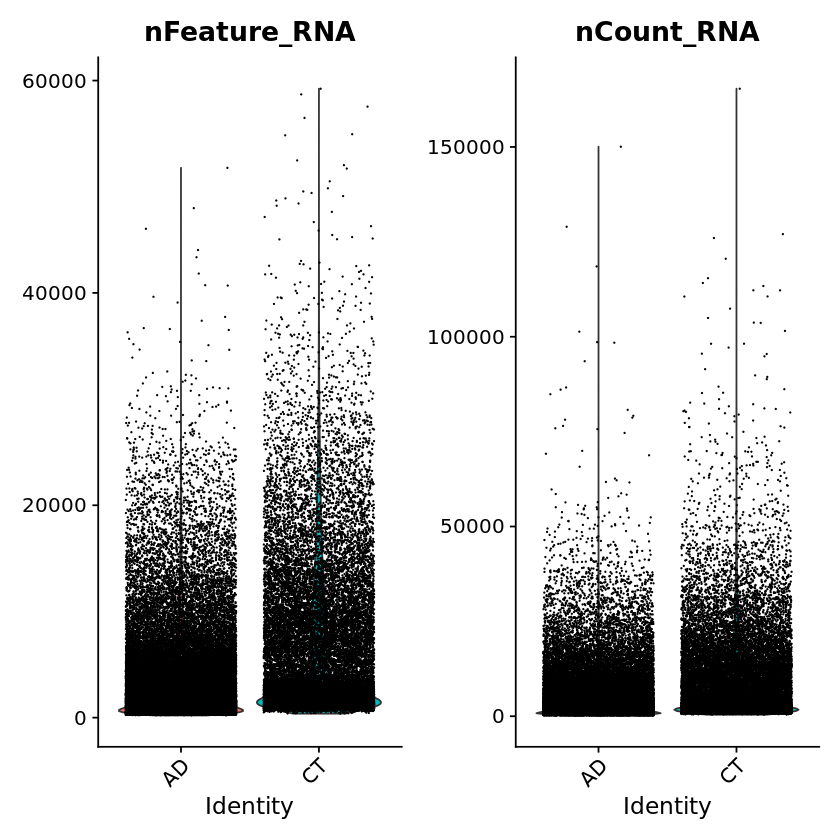

In [8]:
VlnPlot(peaks_so_sfg, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

In [9]:
mean(peaks_so_sfg$nCount_RNA)

[1] 5425.423

In [10]:
mean(peaks_so_sfg$nFeature_RNA)

[1] 4019.825

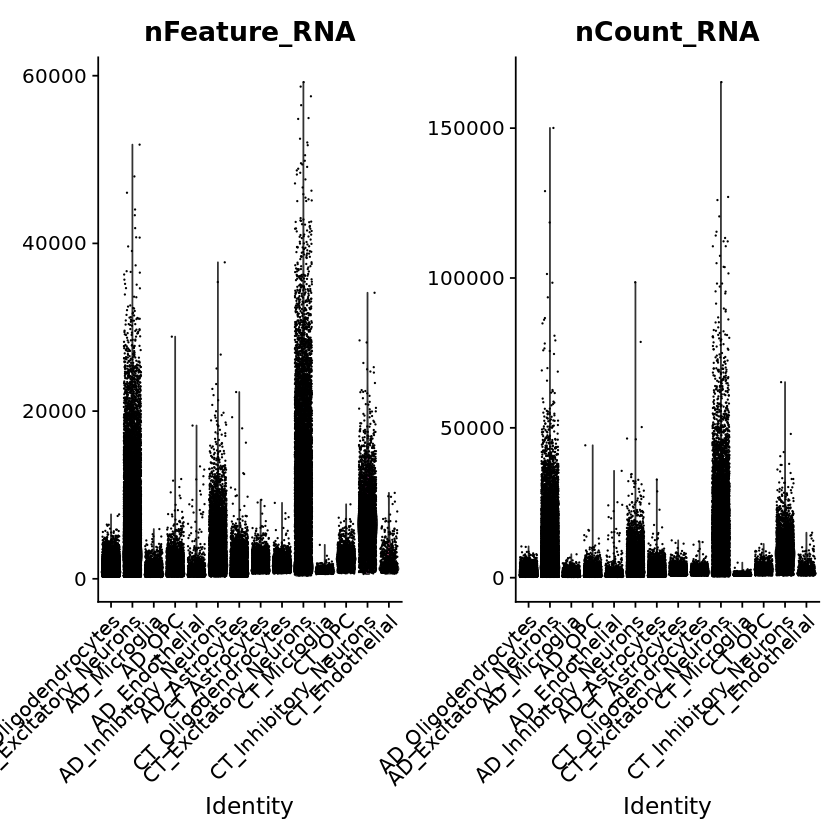

In [11]:
peaks_so_sfg <- SetIdent(peaks_so_sfg , value = peaks_so_sfg$main_celltype)
VlnPlot(peaks_so_sfg, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

In [19]:
samples <- sub(".*-1_(.*)","\\1",Cells(peaks_so_sfg))
control_samples <- samples[which(!startsWith(samples , 'SFG'))]

In [27]:
names(table(control_samples))

[1] "4341_BA46"     "5387_BA9"      "5408_PFC_Nova" "5538_PFC_Nova"
 [5] "5577_BA9"      "5879_PFC_Nova" "5893_PFC"      "5936_PFC_Nova"
 [9] "5958_BA9"      "5976_BA9"

In [5]:
## lets subset to AD and Ct and then make peaks_stat df for each

ct_peaks_so <- subset(peaks_so_sfg, subset=cond=="CT")
ad_peaks_so <- subset(peaks_so_sfg, subset=cond=='AD')

In [29]:
ct_peaks_so$samples <- sub(".*-1_(.*)","\\1",Cells(ct_peaks_so))

In [30]:
ad_peaks_so$samples <- sub("(.*)_.*","\\1",Cells(ad_peaks_so))

In [31]:
table(ct_peaks_so$samples)


    4341_BA46      5387_BA9 5408_PFC_Nova 5538_PFC_Nova      5577_BA9 
         3849          6541          2255          3034          4131 
5879_PFC_Nova      5893_PFC 5936_PFC_Nova      5958_BA9      5976_BA9 
         1850          3317          2033          2083          1054 

In [32]:
table(ad_peaks_so$samples)


 SFG1 SFG10  SFG2  SFG3  SFG4  SFG5  SFG6  SFG8  SFG9 
 2517  7709  6541  3587  6254  6484  3946 12825 10832 

In [33]:
count_per_sample <- data.frame(samples=ct_peaks_so$samples, peak_count=ct_peaks_so$nCount_RNA,
                               features=ct_peaks_so$nFeature_RNA)
count_per_sample <- count_per_sample %>%
  group_by(samples) %>%
  summarise(median_peak_count = median(peak_count), median_feature_count=median(features))
count_per_sample

samples       median_peak_count median_feature_count
1  4341_BA46     2829.0            2387.0              
2  5387_BA9      3862.0            3301.0              
3  5408_PFC_Nova 2825.0            2332.0              
4  5538_PFC_Nova 3231.0            2508.0              
5  5577_BA9      2620.0            2237.0              
6  5879_PFC_Nova 3309.5            2713.5              
7  5893_PFC      2649.0            2148.0              
8  5936_PFC_Nova 3056.0            2501.0              
9  5958_BA9      6034.0            5001.0              
10 5976_BA9      2594.0            2144.0

In [34]:
write.table(count_per_sample, file='results/Dim_peaks_stats.tsv', sep='\t')

In [35]:
count_per_sample <- data.frame(samples=ad_peaks_so$samples, peak_count=ad_peaks_so$nCount_RNA,
                               features=ad_peaks_so$nFeature_RNA)
count_per_sample <- count_per_sample %>%
  group_by(samples) %>%
  summarise(median_peak_count = median(peak_count), median_feature_count=median(features))
count_per_sample

samples median_peak_count median_feature_count
1 SFG1    1282.0            1035.0              
2 SFG10   2254.0            1810.0              
3 SFG2    1728.0            1435.0              
4 SFG3    1187.0            1006.0              
5 SFG4    1618.5            1362.5              
6 SFG5    2554.0            2069.0              
7 SFG6    2220.5            1699.0              
8 SFG8    1514.0            1290.0              
9 SFG9    2669.0            2168.0

In [36]:
write.table(count_per_sample, file='results/Kapmann_peaks_stats.tsv', sep='\t')

In [8]:
write.table(ad_peaks_so@meta.data, file='rdata/ad_metadata.tsv')

In [1]:
ct_peaks_so

ERROR: Error in eval(expr, envir, enclos): object 'ct_peaks_so' not found


In [ ]:
ct_peaks_so